# Aerobic bacterial degradation of aromatics using AromaDeg
This notebook is part of the analysis of the TotalRNA mRNA genes from Trinity. 

See more [here](https://academic.oup.com/database/article/doi/10.1093/database/bau118/2635556?login=true).

![Aerobic bacterial degradation of aromatics using AromaDeg](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/database/2014/10.1093_database_bau118/2/m_bau118f1p.jpeg?Expires=1701436349&Signature=toT-97NN22e637r0SW5FmRMWKdphA79aJPVYMfVP10IWJ0HcRHogOyNZoN2QnoCAz8D2e0nETxiVqQ9Vz7y~2cBSUdQ~gSk4RMc8DynogNuprLY93kP-kyeRLJR3IumekkbhUeihSu9kjUWpq61moQLI7~5-tiZSKx1eF0G3UIR94ofsOUpUzKrY7onfFKZqZQbwqcT9vVUGcQ-7vPM9ixU9rSWmRCVqs4zVn6wXWdxbTXVSV2xCbbKUSwqeBv0zjb0kCGvlkeiQeTOCkqL4b1lJwqk~H4nHipvUyYM~tKUSK~s7J0RFGSuhRB1IBU6Q87TrhD0Zpz12fqYZclYKbQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)
## How to run Jupyter notebooks in huginn
<details>
<summary>Click to expand!</summary>

If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work, activate the conda enviroment and run jupyter notebook or jupyter lab:
```bash
conda activate jupyter-diamond
jupyter notebook --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```
6. Open your browser and go to `localhost:7777` and you should see the jupyter notebook running in huginn. You can also press in the url of Terminal A. 

Troubleshooting:
- If you get an error like `bind: Address already in use` it means that you have another jupyter notebook running in the same port. You can either kill the process or change the port.
</details>

## How to create a new environment for this notebook (if needed)

We will use Singuliarty, a few python basic libraries and bash. Let's check if those dependencies are installed. If not, you can install them with mamba (as well with jupyterlab)

```bash
# To create a new environment with mamba
mamba create -c bioconda -c conda-forge hmmer pandas matplotlib jupyterlab -n jupyter-diamond
# To activate the environment
conda activate jupyter-diamond
```

### Sanity check

In [1]:
%%bash
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
hmmsearch -h | head -n 1
bash --version | head -n 1

1.1.5
3.3.4
# hmmsearch :: search profile(s) against a sequence database
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

### Input files (edit this chunk)
Edit this chunk to match your input files

In [3]:
trinity_file = '../data/contigs.fasta'
count_table = '../data/mapped_reads_to_contigs.tsv'

In [4]:
## Sanity check: trinity and count table exit
assert os.path.exists(trinity_file), 'Trinity file does not exist'
assert os.path.exists(count_table), 'Count table does not exist'

### Output files (edit this chunk)
Edit this chunk to match your desired output files

In [5]:
outfile_matches = '../results/aromadeg_matches.out'

### Database files
Don't edit this chunk

In [6]:
database_dir = '/data_2/Databases/AromaDeg/'
assert os.path.exists(database_dir), 'Database directory does not exist'

##### Run hmmsearch

In [7]:
%%bash -s "$database_dir" "$trinity_file" "$outfile_matches"
if [ ! -f $3 ]; then
# Translate DNA into protein sequences
transeq -sequence $2 -outseq $2.tmp -frame 6
# Get all *.hmm files in the database directory
hmm_files=$(find $1 -name "*.hmm")
# Run hmmsearch for each hmm file
for hmm_file in $hmm_files; do
  echo "Processing $hmm_file"
  hmmsearch --tblout $3.tmp $hmm_file $2.tmp > /dev/null
  # Append the results to the output file
  cat $3.tmp >> $3
  rm $3.tmp
done
rm $2.tmp
fi
head $3

Processing /data_2/Databases/AromaDeg/Gentisate.hmm
Processing /data_2/Databases/AromaDeg/EXDO_miscelaneous.hmm
Processing /data_2/Databases/AromaDeg/EXDO_1_2.hmm
Processing /data_2/Databases/AromaDeg/EXDO_1_3.hmm
Processing /data_2/Databases/AromaDeg/LigB_protocat.hmm
Processing /data_2/Databases/AromaDeg/Rieske_Salicylate.hmm
Processing /data_2/Databases/AromaDeg/Rieske_biphenyl.hmm
Processing /data_2/Databases/AromaDeg/Rieske_Benzoate.hmm
Processing /data_2/Databases/AromaDeg/Rieske_Phthalate.hmm
Processing /data_2/Databases/AromaDeg/LigB_homoprotocat.hmm
#                                                                         --- full sequence ---- --- best 1 domain ---- --- domain number estimation ----
# target name                  accession  query name           accession    E-value  score  bias   E-value  score  bias   exp reg clu  ov env dom rep inc description of target
#          ------------------- ---------- -------------------- ---------- --------- ------ ----- --------

Translate nucleic acid sequences


##### Preprocessing HMMER matches
We read the file into a pandas table:

In [8]:
def parse_hmmer(line):
    line = line.split()
    return pd.Series(
        {
            "target_name": line[0],
            "query_name": line[2],
            "evalue": float(line[4]),
            "score": float(line[5]),
        }
    )

In [9]:
hmmer = pd.DataFrame(
        [
            parse_hmmer(line)
            for line in open(outfile_matches)
            if not line.startswith("#")
        ],
    )
hmmer

,target_name,query_name,evalue,score
0,TRINITY_DN787864898_c0_g1_i1_1,Gentisate,1.400000e-88,289.0
1,TRINITY_DN787864898_c0_g1_i1_2,EXDO_miscelaneous,2.800000e-26,84.1
2,TRINITY_DN787864898_c0_g1_i1_2,EXDO_1_2,2.000000e-30,97.8
3,TRINITY_DN787864898_c0_g1_i1_2,EXDO_1_3,5.800000e-97,316.2
4,TRINITY_DN787864898_c0_g1_i1_2,Rieske_Salicylate,2.600000e-52,169.6
5,TRINITY_DN787864898_c0_g1_i1_2,Rieske_biphenyl,1.300000e-147,484.0
6,TRINITY_DN787864898_c0_g1_i1_2,Rieske_Benzoate,2.100000e-84,275.4
7,TRINITY_DN787864898_c0_g1_i1_2,Rieske_Phthalate,2.700000e-25,80.5


Because we have translated the sequences, our target names now have the suffix _i (where i is the reading frame). We will remove this suffix to make the names match the original sequences.

In [10]:
# Remove last 2 characters from the target name
hmmer['target_name'] = hmmer['target_name'].str[:-2]
hmmer

,target_name,query_name,evalue,score
0,TRINITY_DN787864898_c0_g1_i1,Gentisate,1.400000e-88,289.0
1,TRINITY_DN787864898_c0_g1_i1,EXDO_miscelaneous,2.800000e-26,84.1
2,TRINITY_DN787864898_c0_g1_i1,EXDO_1_2,2.000000e-30,97.8
3,TRINITY_DN787864898_c0_g1_i1,EXDO_1_3,5.800000e-97,316.2
4,TRINITY_DN787864898_c0_g1_i1,Rieske_Salicylate,2.600000e-52,169.6
5,TRINITY_DN787864898_c0_g1_i1,Rieske_biphenyl,1.300000e-147,484.0
6,TRINITY_DN787864898_c0_g1_i1,Rieske_Benzoate,2.100000e-84,275.4
7,TRINITY_DN787864898_c0_g1_i1,Rieske_Phthalate,2.700000e-25,80.5


We also add the count table into a Pandas data frame:

In [11]:
counts = pd.read_csv(
    count_table, sep = "\t", comment='#'
).set_index('ContigID')
counts

,SampleA,SampleB,SampleC,SampleD,SampleE
ContigID,,,,,
TRINITY_DN226500_c0_g1_i1,0,0,2,1,0
TRINITY_DN226510_c0_g1_i1,1,0,0,0,5
TRINITY_DN226477_c0_g1_i1,0,0,0,0,0
TRINITY_DN226449_c0_g1_i1,0,0,2,0,0
TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
TRINITY_DN226454_c0_g1_i1,0,0,0,9,0
TRINITY_DN226455_c0_g1_i1,0,2,0,0,2
TRINITY_DN2264898_c0_g1_i1,0,2,1,1,2
TRINITY_DN787864898_c0_g1_i1,0,2,1,1,20


# Preprocessing

## Most significant hit per Contig
Now, we need to get the most significant hit per each contig ID. Let's inspect how many hits there are per contig (adjust the number of bins). 

Text(0.5, 1.0, 'Number of hits per contig')

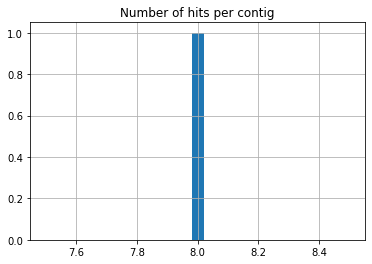

In [12]:
hmmer.pivot_table(columns=["target_name"], aggfunc="size").hist(bins=25)
plt.title("Number of hits per contig")

In this case, we are going to sort rows per e-value and score and get the most significant hit per each ContigId.

In [13]:
hmmer = (
    hmmer.sort_values(by=["evalue", "score"], ascending=[True, False])
    .drop_duplicates("target_name", keep="first")
    .set_index("target_name")
)
hmmer

,query_name,evalue,score
target_name,,,
TRINITY_DN787864898_c0_g1_i1,Rieske_biphenyl,1.300000e-147,484.0


### Inspect E-values from aligned orthologous genes before filtering by e-value

array([[<AxesSubplot:title={'center':'evalue'}>]], dtype=object)

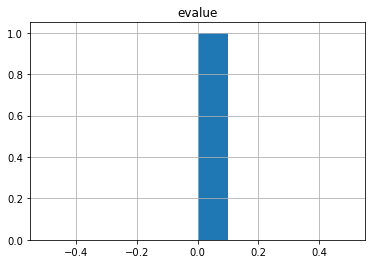

In [14]:
hmmer.hist("evalue")

### Inspect E-values from aligned orthologous genes after filtering by e-value

We need to set a threshold:

array([[<AxesSubplot:title={'center':'evalue'}>]], dtype=object)

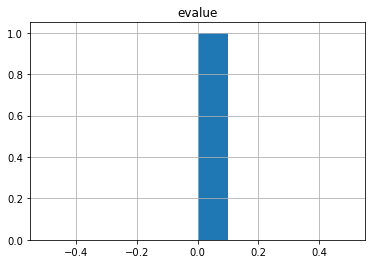

In [15]:
evalue_threshold = 0.0001
hmmer = hmmer.loc[hmmer["evalue"] < evalue_threshold]
hmmer.hist("evalue")

In [16]:
val = len(set(hmmer["query_name"]))
print(f"There are {val} unique orthologous genes")

There are 1 unique orthologous genes


### Merging aligned genes and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header (to obtain map table).

In [17]:
map_table = hmmer[["query_name"]]
map_table

,query_name
target_name,
TRINITY_DN787864898_c0_g1_i1,Rieske_biphenyl


Now, we are going to merge both files by their column in common (target_name and query_name).

In [18]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(
    drop=True
)
df

,query_name,SampleA,SampleB,SampleC,SampleD,SampleE
0,Rieske_biphenyl,0,2,1,1,20


##### Aggregate table
Now, we are going to aggregate the rows by grouping them by "Subject id" (notice the difference in rows between the previous table and the following):

In [19]:
df = df.groupby('query_name').sum(numeric_only = False)
df

,SampleA,SampleB,SampleC,SampleD,SampleE
query_name,,,,,
Rieske_biphenyl,0,2,1,1,20


Finally, we save the table and remove the temporary files:

In [20]:
df.to_csv('../results/aromadeg_matches_annotated.tsv', sep='\t')